**Goal**

This is a covid-19 analysis notebook

We are trying to predict # num of covid-19 patients from each states for a 2-week date range.

Algorithim used: Multi step LSTM using univariate features 

Reference :https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/


There are three assumption that we are making here 
Assumption 1: We are assuming following to be demographics of India 

25 % - very young 0 - 18 

45% - youth  

30% - senior citizen (55+) 

We are observing over a period of time -65% of total predicted patients  will require hospitalization


Assumption 2: out of total beds availale in state only 5% of beds are available for corona patients 


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
covid_data = pd.read_csv("/kaggle/input/covid19-in-india/covid_19_india.csv")
state_test_data = pd.read_csv("/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv")
individuals_details_data = pd.read_csv("/kaggle/input/covid19-in-india/IndividualDetails.csv")
population_india = pd.read_csv("/kaggle/input/covid19-in-india/population_india_census2011.csv")
hospital_beds=pd.read_csv("/kaggle/input/covid19-in-india/HospitalBedsIndia.csv")

In [16]:
print(" covid_19_india data")
covid_data.head()
print("StatewiseTestingDetails")
print(state_test_data.head())
print("population_india_census2011")
print(population_india.head())
#print(covid_data.columns)
covid_data_grouped=covid_data[covid_data['Date']==covid_data['Date'].max()]
covid_data_grouped=covid_data_grouped.loc[:,['State/UnionTerritory','Cured','Deaths', 'Confirmed']]
covid_data_grouped.columns=['State','Cured','Deaths', 'Confirmed']
covid_data_grouped.columns

 covid_19_india data
StatewiseTestingDetails
         Date                        State  TotalSamples  Negative  Positive
0  2020-04-17  Andaman and Nicobar Islands        1403.0    1210.0      12.0
1  2020-04-24  Andaman and Nicobar Islands        2679.0       NaN      27.0
2  2020-04-27  Andaman and Nicobar Islands        2848.0       NaN      33.0
3  2020-05-01  Andaman and Nicobar Islands        3754.0       NaN      33.0
4  2020-05-16  Andaman and Nicobar Islands        6677.0       NaN      33.0
population_india_census2011
   Sno State / Union Territory  Population  Rural population  \
0    1           Uttar Pradesh   199812341         155317278   
1    2             Maharashtra   112374333          61556074   
2    3                   Bihar   104099452          92341436   
3    4             West Bengal    91276115          62183113   
4    5          Madhya Pradesh    72626809          52557404   

   Urban population                         Area                  Density  \
0  

Index(['State', 'Cured', 'Deaths', 'Confirmed'], dtype='object')

Travel notes from air passangers


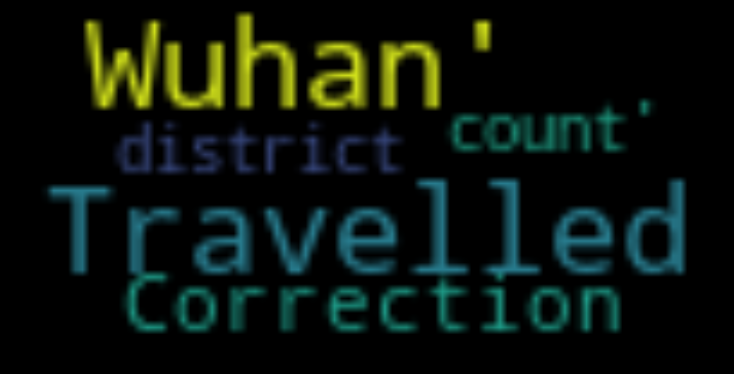

In [17]:
print("Travel notes from air passangers")
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = individuals_details_data.notes.values
wordcloud = WordCloud(
    width = 100,
    height = 50,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
#covid_data_grouped.head(50)

[Text(0, 0.5, 'State/UT'), Text(0.5, 0, 'Total cases')]

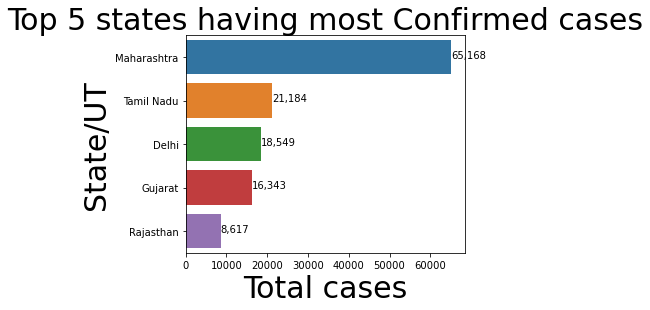

In [18]:
top_deaths=covid_data_grouped.sort_values(by='Confirmed',ascending=False)[0:5]
import seaborn as sns
plt.figure(figsize= (5,4))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Confirmed cases",fontsize = 30)
plt.ylabel('State',fontsize = 30)
plt.title("Top 5 states having most Confirmed cases" , fontsize = 30)
ax = sns.barplot(x = top_deaths.Confirmed, y = top_deaths.State)
for i, (value, name) in enumerate(zip(top_deaths.Confirmed,top_deaths.State)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='State/UT')

[Text(0, 0.5, 'State/UT'), Text(0.5, 0, 'Total cases')]

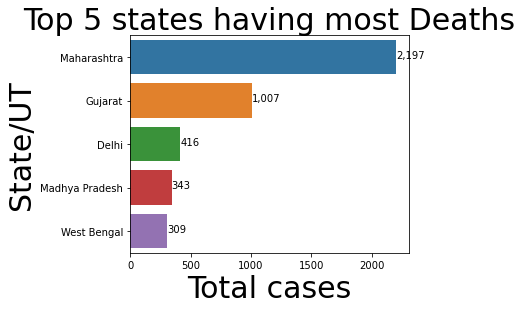

In [19]:
top_deaths=covid_data_grouped.sort_values(by='Deaths',ascending=False)[0:5]
import seaborn as sns
plt.figure(figsize= (5,4))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Confirmed cases",fontsize = 30)
plt.ylabel('State',fontsize = 30)
plt.title("Top 5 states having most Deaths" , fontsize = 30)
ax = sns.barplot(x = top_deaths.Deaths, y = top_deaths.State)
for i, (value, name) in enumerate(zip(top_deaths.Deaths,top_deaths.State)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='State/UT')

**DEEP DIVE ANALYSIS TO PREDICT # OF POSITIVE CASES FOR TWO WEEK BASED ON LAST FEW WEEK DATA** 

In [20]:
print(population_india.columns)
#print(state_data_distibution.columns)
print(covid_data_grouped.columns)

Index(['Sno', 'State / Union Territory', 'Population', 'Rural population',
       'Urban population', 'Area', 'Density', 'Gender Ratio'],
      dtype='object')
Index(['State', 'Cured', 'Deaths', 'Confirmed'], dtype='object')


Loading containmnet zones data  found from other source

In [21]:
containment_zones = pd.read_excel("/kaggle/input/containment-zones-new/containment_zones.csv.xlsx")
containment_zones.head()
containment_zones_grouped=containment_zones.loc[containment_zones['Classification']=='Red Zone'].groupby('State')['Classification'].count().reset_index()
containment_zones_grouped.columns=['State','num_containment_zones']
containment_zones_grouped.head()

,State,num_containment_zones
0,Andhra Pradesh,5
1,Bihar,5
2,Chandigarh,1
3,Gujarat,9
4,Haryana,2


**Preparing dataset for Univariate LSTM Analysis**

In [22]:
#Merging all dataset
#covid_data_distribution=pd.merge(pd.merge(covid_data,state_test_data,how='right', \
#                                 left_on=['State/UnionTerritory','Date'] ,right_on=['State','Date']), \
#                                 population_india, \
#                                 how='left', right_on='State / Union Territory',left_on='State/UnionTerritory')


covid_data_distribution=pd.merge(state_test_data,population_india, how='left',left_on=['State'],right_on='State / Union Territory')
                                
#print(covid_data_distribution.shape)
covid_data_distribution['State']=covid_data_distribution['State'].str.strip()
#print(covid_data_distribution.isnull().sum())
#Merging containmnet _zone data 

covid_data_distribution=pd.merge(covid_data_distribution,containment_zones_grouped[['num_containment_zones','State']],
                         on='State',how='left')
covid_data_distribution['PopulationDensity']=covid_data_distribution['Density'].str.replace(',',"").str.split('/km2').str[0].astype(float)
covid_data_distribution.fillna(covid_data_distribution['PopulationDensity'].mean(),inplace=True)
covid_data_distribution['PopulationDensity'].unique()

covid_data_distribution['weighted_density']=np.log(covid_data_distribution['PopulationDensity'])*covid_data_distribution['num_containment_zones']

Model-Univariate LSTM
Features used : Total positive cases 
Timesteps used :5

In [23]:
import pandas as pd
import numpy as np
from math import ceil
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten
from tensorflow.keras import optimizers

#By looking at data we realise Density and num_containmnet_zones will be same throughout for each state .
That is why going ahead only with num of positive patient as a feature for univariate LSTM Model


In [24]:
print(covid_data_distribution.columns)
#Retaining columns required for model

df=covid_data_distribution.loc[:,['Date','State','Positive']]
df.sort_values(by=['State','Date'],inplace=True)
df.isnull().sum()
df.columns

Index(['Date', 'State', 'TotalSamples', 'Negative', 'Positive', 'Sno',
       'State / Union Territory', 'Population', 'Rural population',
       'Urban population', 'Area', 'Density', 'Gender Ratio',
       'num_containment_zones', 'PopulationDensity', 'weighted_density'],
      dtype='object')


Index(['Date', 'State', 'Positive'], dtype='object')

Now we will prepare data for training and validation as required by LSTM layer for input .
Here for each state covid-19 patients is being predicted by looking at its past data for 10-days.
Since hospitals/ authorities need to know a few time step ahead about requiremnet , we are predicting output for next 7 days 

In [25]:
# Filling missing values 
final_df_all=pd.DataFrame()

for state in df.State.unique():
    #print(chosen_ip) 
    chosen_state_data=df[df['State']==state].sort_values('Date')
    
    chosen_state_data['Date']=pd.to_datetime(chosen_state_data['Date'],format='%Y-%m-%d') 
    dataset_all_date=pd.DataFrame(pd.date_range(start='2020-04-01',end='2020-05-31',freq='D'),
                                        columns=['DailyDate'])
    final_df = dataset_all_date.merge(chosen_state_data,
                                        how='left',
                                            left_on='DailyDate',
                                            right_on='Date')

    #print(final_df['Positive'].isnull().sum())
    final_df['Positive'].ffill(axis='rows',inplace=True)
    final_df['Positive'].fillna(0,inplace=True)
    final_df['State'].fillna(state,inplace=True)
    #print(final_df['Positive'].isnull().sum()) 
    final_df.drop(labels='Date',axis=1,inplace=True)
    #print(final_df.count())
    final_df_all=final_df_all.append(final_df)
    
#CReating timesteps for univariate LSTM
x_train_df=[]
y_train_df=[]
max_all=[]
min_all=[]
sc=MinMaxScaler()
n_steps=10
future_days=7
for State in final_df_all['State'].unique():
    final_df=final_df_all[final_df_all['State']==State]
    final_df.sort_values(by='DailyDate',ascending=True)
    #for i in range(n_steps,len(final_df)-1):
    for i in range(n_steps,len(final_df)-future_days-n_steps):
        print(i,i-n_steps,i+future_days-1)
        #print(final_df.Positive.iloc[i+future_days-1:i+future_days].values.reshape(-1,1))
        x_train_steps=final_df.Positive.iloc[i-n_steps:i].values.reshape(-1,1)
        y_train_steps=final_df.Positive.iloc[i+future_days-1:i+future_days].values.reshape(-1,1)
        #print(y_train_steps)
        x_train_scaled=sc.fit_transform(x_train_steps)
        y_train_scaled=sc.transform(y_train_steps)
        x_train_df.append(x_train_scaled)
        y_train_df.append(y_train_scaled)
        max=sc.data_max_
        min=sc.data_min_
        max_all.append(max)
        min_all.append(min)
x_train=np.array(x_train_df)
y_train=np.array(y_train_df)
max_all_train=np.array(max_all)
min_all_train=np.array(min_all)
print(x_train.shape,y_train.shape)

10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13

41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10 26
21 11 27
22 12 28
23 13 29
24 14 30
25 15 31
26 16 32
27 17 33
28 18 34
29 19 35
30 20 36
31 21 37
32 22 38
33 23 39
34 24 40
35 25 41
36 26 42
37 27 43
38 28 44
39 29 45
40 30 46
41 31 47
42 32 48
43 33 49
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
19 9 25
20 10

In [26]:
#preparing validation data
final_df_all=pd.DataFrame()

for state in df.State.unique():
    #print(chosen_ip) 
    chosen_state_data=df[df['State']==state].sort_values('Date')
    
    chosen_state_data['Date']=pd.to_datetime(chosen_state_data['Date'],format='%Y-%m-%d') 
    dataset_all_date=pd.DataFrame(pd.date_range(start='2020-05-10',end='2020-06-04',freq='D'),
                                        columns=['DailyDate'])
    final_df = dataset_all_date.merge(chosen_state_data,
                                        how='left',
                                            left_on='DailyDate',
                                            right_on='Date')

    #print(final_df['Positive'].isnull().sum())
    final_df['Positive'].ffill(axis='rows',inplace=True)
    final_df['Positive'].fillna(0,inplace=True)
    final_df['State'].fillna(state,inplace=True)
    #print(final_df['Positive'].isnull().sum()) 
    final_df.drop(labels='Date',axis=1,inplace=True)
    #print(final_df.count())
    final_df_all=final_df_all.append(final_df)
#print(final_df_all.shape)    
#CReating timesteps for univariate LSTM
x_test_df=[]
y_test_df=[]
y_state_test_df=[]
y_date_df=[]
max_all=[]
min_all=[]
y_test_unscaled=[]
sc=MinMaxScaler()
n_steps=10
future_days=7

for State in final_df_all['State'].unique():
    final_df=final_df_all[final_df_all['State']==State]
    final_df.sort_values(by='DailyDate',ascending=True)
    #print(final_df.shape)
    for i in range(n_steps,len(final_df)-future_days):
        print(i,i-n_steps,i+future_days-1)
        x_test_steps=final_df.Positive.iloc[i-n_steps:i].values.reshape(-1,1)
        #print(final_df.Positive.iloc[i-n_steps:i].values.reshape(-1,1))
        y_test_steps=final_df.Positive.iloc[i+future_days-1:i+future_days].values.reshape(-1,1)
        #print(x_test_steps.shape)
        x_test_scaled=sc.fit_transform(x_test_steps)
        y_test_scaled=sc.transform(y_test_steps)
        x_test_df.append(x_test_scaled)
        y_test_df.append(y_test_scaled)
        y_state=final_df['State'].unique()
        y_date=final_df.DailyDate.iloc[i+future_days-1:i+future_days].unique()
        y_test_steps=final_df.Positive.iloc[i+future_days-1:i+future_days].unique()
        y_test_unscaled.append(y_test_steps)
        y_state_test_df.append(y_state)
        y_date_df.append(y_date)
        max=sc.data_max_
        min=sc.data_min_
        max_all.append(max)
        min_all.append(min)
x_test=np.array(x_test_df)
y_test=np.array(y_test_df)
y_state_test=np.array(y_state_test_df)
y_date=np.array(y_date_df)
y_test_unscaled_all=np.array(y_test_unscaled)
max_all_test=np.array(max_all)
min_all_test=np.array(min_all)

10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23
18 8 24
10 0 16
11 1 17
12 2 18
13 3 19
14 4 20
15 5 21
16 6 22
17 7 23


Checking shape of data -is it fit for LSTM input

In [27]:
print(y_state_test.shape)
print(y_test.shape)
print(y_date.shape)
print(y_test_unscaled_all.shape)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(x_train.shape ,x_test.shape)
y_train=y_train.reshape(x_train.shape[0])
y_test=y_test.reshape(y_test.shape[0])
y_state_test=y_state_test.reshape(y_state_test.shape[0])
y_date=y_date.reshape(y_date.shape[0])
y_test_unscaled=y_test_unscaled_all.reshape(y_test_unscaled_all.shape[0])
print(y_train.shape,y_test.shape,y_state_test.shape,y_date.shape,y_test_unscaled.shape)
max_all_test=max_all_test.reshape(max_all_test.shape[0])
min_all_test=min_all_test.reshape(min_all_test.shape[0])


(315, 1)
(315, 1, 1)
(315, 1)
(315, 1)
(1192, 10, 1) (1192, 1, 1) (315, 10, 1) (315, 1, 1)
(1192, 10, 1) (315, 10, 1)
(1192,) (315,) (315,) (315,) (315,)


LSTM Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
num_epoch=100
batch_size=48
lr=0.0001
optimizer = keras.optimizers.Adam(learning_rate=lr)
lstm_units=30
model=Sequential()
model.add(LSTM(units=lstm_units,input_shape=(x_train.shape[1],1)))
model.add(Dense(units=20,activation='relu'))
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=1,activation='relu'))
model.compile(optimizer=optimizer,loss='mean_absolute_error')

Using TensorFlow backend.


In [29]:
model.fit(x_train,y_train,
          batch_size=60,
          epochs=100,
         validation_data=(x_test,y_test))

Train on 1192 samples, validate on 315 samples
Epoch 1/100
1192/1192 [==============================] - 1s 796us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 2/100
1192/1192 [==============================] - 0s 193us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 3/100
1192/1192 [==============================] - 0s 195us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 4/100
1192/1192 [==============================] - 0s 184us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 5/100
1192/1192 [==============================] - 0s 192us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 6/100
1192/1192 [==============================] - 0s 191us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 7/100
1192/1192 [==============================] - 0s 196us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 8/100
1192/1192 [==============================] - 0s 187us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 9/100
1192/1192 [==============================] - 0s 195us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 10

Epoch 78/100
1192/1192 [==============================] - 0s 185us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 79/100
1192/1192 [==============================] - 0s 180us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 80/100
1192/1192 [==============================] - 0s 179us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 81/100
1192/1192 [==============================] - 0s 191us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 82/100
1192/1192 [==============================] - 0s 182us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 83/100
1192/1192 [==============================] - 0s 185us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 84/100
1192/1192 [==============================] - 0s 185us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 85/100
1192/1192 [==============================] - 0s 196us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 86/100
1192/1192 [==============================] - 0s 187us/step - loss: 9.8645 - val_loss: 3.3278
Epoch 87/100
1192/1192 [======================

In [30]:
y_predict_train=model.predict(x_train)
y_predict_test=model.predict(x_test)

#Flatenning data frame
y_train_flatten=np.array(y_train).ravel()
y_predict_train_flatten=np.array(y_predict_train).ravel()

y_test_flatten=np.array(y_test).ravel()
y_predict_test_flatten=np.array(y_predict_test).ravel()

y_state_test_flatten=np.array(y_state_test).ravel()
y_date_flatten=np.array(y_date).ravel()

max_all_train=np.array(max_all_train).ravel()
min_all_train=np.array(min_all_train).ravel()

max_all_tets=np.array(max_all_test).ravel()
min_all_tets=np.array(min_all_test).ravel()

In [31]:

df_loss_train=pd.DataFrame(list(zip(y_train_flatten,y_predict_train_flatten,max_all_train,min_all_train)),
               columns=['y_train','y_predicted','max_value','min_value'])

print(df_loss_train.shape)
df_loss_train['diff']=df_loss_train['max_value']-df_loss_train['min_value']
df_loss_train['y_train_unscaled']=(df_loss_train['y_train']*(df_loss_train['diff']))+df_loss_train['min_value']
df_loss_train['y_predicted_unscaled']=(df_loss_train['y_predicted']*(df_loss_train['diff']))+df_loss_train['min_value']
df_loss_train=pd.DataFrame(list(zip(y_train_flatten,y_predict_train_flatten,max_all_train,min_all_train)),
               columns=['y_train','y_predicted','max_value','min_value'])

df_loss_train['diff']=df_loss_train['max_value']-df_loss_train['min_value']
df_loss_train['y_train_unscaled']=(df_loss_train['y_train']*(df_loss_train['diff']))+df_loss_train['min_value']
df_loss_train['y_predicted_unscaled']=(df_loss_train['y_predicted']*(df_loss_train['diff']))+df_loss_train['min_value']
#df_loss_train.head(200)

(1192, 4)


In [32]:

df_loss_test=pd.DataFrame(list(zip(y_test_flatten,y_predict_test_flatten,max_all_test,min_all_test,y_state_test_flatten,y_date_flatten,y_test_unscaled)),
               columns=['y_test','y_predicted','max_value','min_value','State','Date','y_test_unscaled'])
df_loss_test['diff']=df_loss_test['max_value']-df_loss_test['min_value']
df_loss_test['y_test_unscaled']=df_loss_test['y_test']*(df_loss_test['diff'])+df_loss_test['min_value']
df_loss_test['y_predicted_unscaled']=(df_loss_test['y_predicted']*(df_loss_test['diff']))+df_loss_test['min_value']

Predictions from 26th May to June 3rd

Assumption 1: Going by demographics of India where age -demograpics are as following:-
25 % - very young 0 - 18 
45% - youth  
30% - senior citizen (55+) 
Here we are assuming 50% young and youth will require hospitalization from the total number of predicted patients


In [ ]:
'''print(population_india.columns)
#population=
print(df_loss_test.columns)
#Merging to obtain demographics data 
test_predicted_data=pd.merge(df_loss_test,population_india[['Population','State / Union Territory']],how='left',left_on='State',right_on='State / Union Territory')
test_predicted_data['Young_and_Youth']=np.round((test_predicted_data['Population']*0.7),0)
test_predicted_data['Senior_Citizen']=np.round((test_predicted_data['Population']*0.3),0)
test_predicted_data['Hospitilization_required']=np.round((0.5*test_predicted_data['Young_and_Youth']),0)+test_predicted_data['Senior_Citizen']
'''

In [33]:
df_loss_test['Hospitilization_required']=np.round((0.65*df_loss_test['y_predicted_unscaled']),0)

In [34]:
df_loss_test.columns

Index(['y_test', 'y_predicted', 'max_value', 'min_value', 'State', 'Date',
       'y_test_unscaled', 'diff', 'y_predicted_unscaled',
       'Hospitilization_required'],
      dtype='object')

In [35]:
#hospitilization_data=test_predicted_data.loc[:,['State','Date','y_test_unscaled','y_predicted_unscaled','Hospitilization_required']]
hospitilization_data=df_loss_test.loc[:,['State','Date','y_test_unscaled','y_predicted_unscaled','Hospitilization_required']]

hospitilization_data.columns=['State','Date','Observed_Patients','Predicted_Patients','Hospitilization_required']


NameError: name 'test_predicted_data' is not defined

In [ ]:
hospitilization_data['Required_Beds']=hospitilization_data['Hospitilization_required']
hospital_beds["Available Beds"]=hospital_beds['NumPublicBeds_HMIS']+hospital_beds['NumRuralBeds_NHP18']+hospital_beds['NumUrbanBeds_NHP18']
hospital_beds["Available_Corona_Beds"]=np.round((0.05*hospital_beds["Available Beds"]),0)

#hospital_beds=hospital_beds.loc[:,['State/UT','Total_Beds']]

In [ ]:
#Merging data to get total no of hospital beds present in india 
hospital_beds['State/UT']=hospital_beds['State/UT'].replace("Andaman & Nicobar Islands","Andaman and Nicobar Islands")
hospital_beds['State/UT']=hospital_beds['State/UT'].replace("Dadra and Nagar Haveli","Dadra and Nagar Haveli and Daman and Diu")
hospital_beds['State/UT']=hospital_beds['State/UT'].replace("Jammu & Kashmir","Jammu and Kashmir")

all_hospitliazation=pd.merge(hospitilization_data,hospital_beds[['State/UT','Available Beds','Available_Corona_Beds']],left_on='State',right_on='State/UT',how='left')

In [ ]:
all_hospitliazation.isnull().sum()


Lets plot gap between required and total beds for each state for month of June

In [ ]:
all_hospitliazation['Gap_in_required_beds']=all_hospitliazation['Required_Beds']-all_hospitliazation['Available_Corona_Beds']

In [ ]:
top_deaths=all_hospitliazation.loc[all_hospitliazation['Date']=='2020-06-01',:].sort_values(by='Gap_in_required_beds',ascending=False)[0:35]
import seaborn as sns
plt.figure(figsize= (10,8))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Gap_in_required_beds",fontsize = 30)
plt.ylabel('State',fontsize = 30)
plt.title("Top 5 states having most Gap in required_beds for 1st June 2020" , fontsize = 30)
ax = sns.barplot(x = top_deaths.Gap_in_required_beds, y = top_deaths.State)
for i, (value, name) in enumerate(zip(top_deaths.Gap_in_required_beds,top_deaths.State)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='State/UT')

In [ ]:
top_deaths=all_hospitliazation.loc[all_hospitliazation['Date']=='2020-06-02',:].sort_values(by='Gap_in_required_beds',ascending=False)[0:35]
import seaborn as sns
plt.figure(figsize= (10,8))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Gap_in_required_beds",fontsize = 30)
plt.ylabel('State',fontsize = 30)
plt.title("Top 5 states having most Gap in required_beds for 2nd June 2020" , fontsize = 30)
ax = sns.barplot(x = top_deaths.Gap_in_required_beds, y = top_deaths.State)
for i, (value, name) in enumerate(zip(top_deaths.Gap_in_required_beds,top_deaths.State)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='State/UT')

In [ ]:
top_deaths=all_hospitliazation.loc[all_hospitliazation['Date']=='2020-06-03',:].sort_values(by='Gap_in_required_beds',ascending=False)[0:35]
import seaborn as sns
plt.figure(figsize= (10,8))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Gap_in_required_beds",fontsize = 30)
plt.ylabel('State',fontsize = 30)
plt.title("Top 5 states having most Gap in required_beds for 3rd June 2020" , fontsize = 30)
ax = sns.barplot(x = top_deaths.Gap_in_required_beds, y = top_deaths.State)
for i, (value, name) in enumerate(zip(top_deaths.Gap_in_required_beds,top_deaths.State)):
    ax.text(value, i-.05, f'{value:,.0f}',  size=10, ha='left',  va='center')
ax.set(xlabel='Total cases', ylabel='State/UT')